# Проект: классификация

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

*Данные о клиентах банка:*

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

*Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:*

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

*Прочие признаки:*

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

***Целевая переменная deposit,*** которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?


In [75]:
df = pd.read_csv('/Users/dariashavronskaia/Desktop/data science/data/bank_fin.csv', sep = ';')

In [76]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?


In [77]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)


In [78]:
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace(',', '.')

In [79]:
df['balance'] = df['balance'].astype(float)

### Задание 4

In [80]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median = df['balance'].median()
df['balance'] = df['balance'].fillna(median)
df['balance'].mean()

1526.9360329690019

### Задание 5

обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения


In [81]:
df['job'] = df['job'].replace('unknown', np.NaN)
df['education'] = df['education'].replace('unknown', np.NaN)

In [82]:
df['job'] = df['job'].fillna(df['job'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])

In [83]:
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

# Фильтруем данные по самой популярной работе и уровню образования
filtered_data = df[(df['job'] == popular_job) & (df['education'] == popular_education)]

In [84]:
filtered_data['balance'].mean()

1598.8829787234042

### Задание 6

удалите все выбросы для признака balance

In [85]:
# Определение квартилей и IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Коэффициент для определения границ
k = 1.5

# Вычисление верхней и нижней границ
upper_bound = Q3 + k * IQR
lower_bound = Q1 - k * IQR

# Вывод результатов
print(f"Верхняя граница: {upper_bound}")
print(f"Нижняя граница: {lower_bound}")

# Фильтр для удаления выбросов
filtered_df = df.loc[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# Вывод результата
print("Исходное количество объектов:", df.shape[0])
print("Количество объектов после удаления выбросов:", filtered_df.shape[0])

Верхняя граница: 4063.0
Нижняя граница: -2241.0
Исходное количество объектов: 11162
Количество объектов после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат


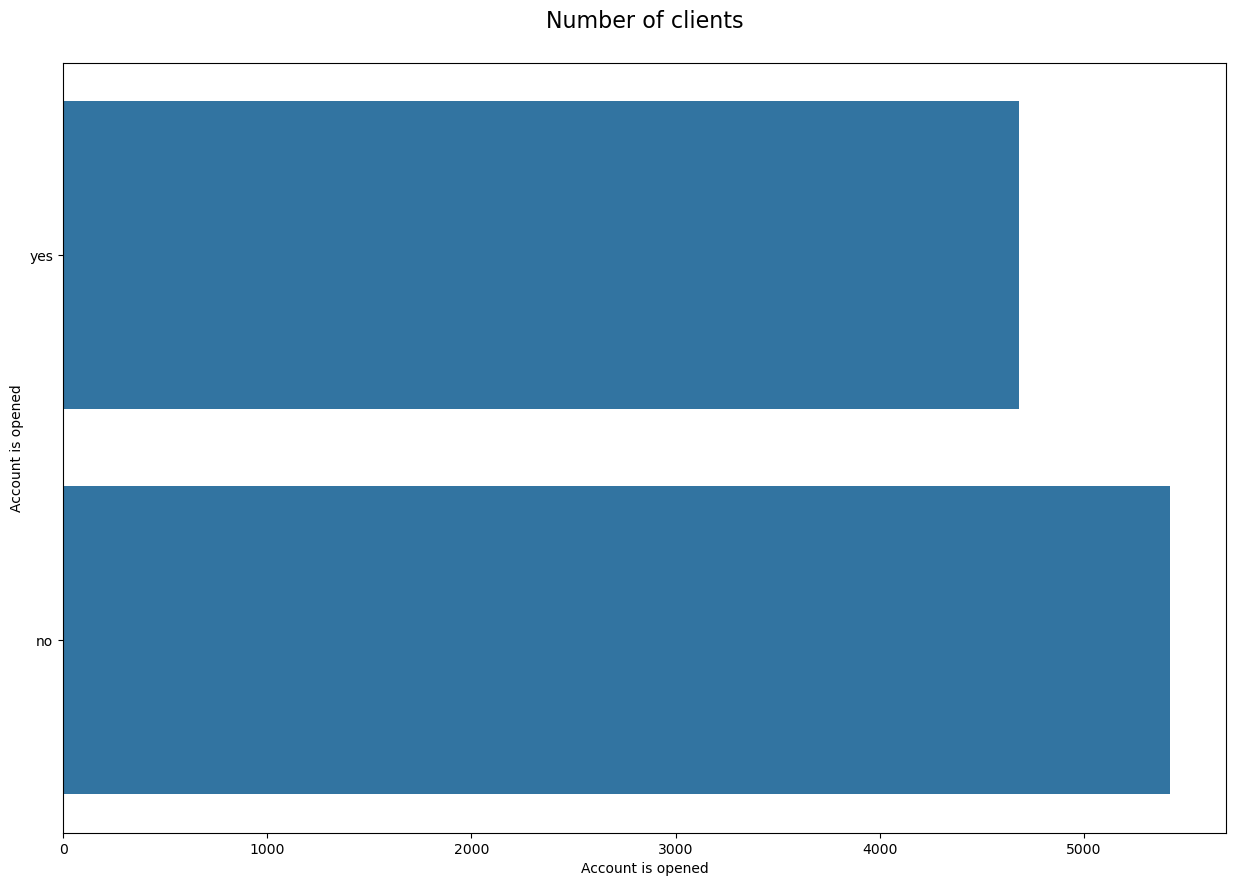

In [89]:
filtered_df['deposit'].value_counts()
ax = sns.countplot(filtered_df['deposit'])
ax.set(xlabel='Account is opened', ylabel='Account is opened')
ax.set_title('Number of clients\n',fontsize=16);

### Задание 2

рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

In [14]:
filtered_df['age'].max()

95

In [15]:
filtered_df["duration"].min()

2

### Задание 3 

рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

In [16]:
filtered_df[filtered_df['campaign'] != 0]['month'].nunique()

12

In [17]:
filtered_df['job'].nunique()

11

### Задание 4

Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.


In [18]:
filtered_df.groupby(['poutcome', 'deposit']).size()

poutcome  deposit
failure   no          562
          yes         547
other     no          216
          yes         265
success   no           84
          yes         861
unknown   no         4562
          yes        3008
dtype: int64

### Задание 5

узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

In [19]:
filtered_df.groupby(['month', 'deposit']).size()

month  deposit
apr    no          317
       yes         513
aug    no          775
       yes         610
dec    no            9
       yes          84
feb    no          323
       yes         386
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    no           24
       yes         213
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    no           62
       yes         273
sep    no           46
       yes         232
dtype: int64

### Задание 6

создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения


In [20]:
# Создаем интервалы для категорий возраста
age_bins = [0, 30, 40, 50, 60, float('inf')]  # Границы категорий: <30, 30-40, 40-50, 50-60, 60+

# Метки для категорий возраста
age_labels = ['<30', '30-40', '40-50', '50-60', '60+']

# Добавляем новый столбец "age_group" с категориями возраста
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

df[df['deposit'] == 'yes']['age_group'].value_counts()


age_group
30-40    1913
40-50    1063
<30       928
50-60     785
60+       600
Name: count, dtype: int64

In [21]:
filtered_df['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

### Задание 7

постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса


In [22]:
filtered_df.groupby(['marital', 'deposit']).size()

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    no         1497
          yes        1716
dtype: int64

### Задание 8

постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
(если рассматривать тех, кто открыл депозит)

In [23]:
deposit_yes_df = filtered_df[filtered_df['deposit'] == 'yes']
deposit_no_df = filtered_df[filtered_df['deposit'] == 'no']
# Создаем сводную таблицу для тех, кто открыл депозит
pivot_table = deposit_yes_df.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

In [24]:
pivot_table

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


## Часть 3: преобразование данных

### Задание 1

преобразуйте уровни образования

In [35]:
from sklearn.preprocessing import LabelEncoder

# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к признаку education
filtered_df['education_encoded'] = label_encoder.fit_transform(filtered_df['education'])

# Вывод суммы получившегося признака
print(filtered_df['education_encoded'].sum())

11995


### Задание 2

преобразуйте бинарные переменные в представление из нулей и единиц


In [36]:
filtered_df['deposit_encoded'] = filtered_df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [37]:
filtered_df['deposit_encoded'].std()

0.4986712532451993

In [38]:
filtered_df['default_encoded'] = filtered_df['default'].apply(lambda x: 1 if x == 'yes' else 0)
filtered_df['housing_encoded'] = filtered_df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
filtered_df['loan_encoded'] = filtered_df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [39]:
print((filtered_df['default_encoded'].mean() + filtered_df['housing_encoded'].mean() + filtered_df['loan_encoded'].mean()).round(3))

0.635


### Задание 3

создание dummy-переменных для номинальных переменных 'job', 'marital', 'contact', 'month', 'poutcome'


In [40]:
# Создание dummy-переменных для номинальных переменных 'job', 'marital', 'contact', 'month', 'poutcome'
dummy_variables = pd.get_dummies(filtered_df[['job', 'marital', 'contact', 'month', 'poutcome']], drop_first=True)
dummy_variables = dummy_variables.astype(int)

# Добавление dummy-переменных к исходному датафрейму
filtered_df = pd.concat([filtered_df, dummy_variables], axis=1)

# Вывод результата
filtered_df.shape

(10105, 50)

In [41]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   job_blue-collar    10105 non-null  int64
 1   job_entrepreneur   10105 non-null  int64
 2   job_housemaid      10105 non-null  int64
 3   job_management     10105 non-null  int64
 4   job_retired        10105 non-null  int64
 5   job_self-employed  10105 non-null  int64
 6   job_services       10105 non-null  int64
 7   job_student        10105 non-null  int64
 8   job_technician     10105 non-null  int64
 9   job_unemployed     10105 non-null  int64
 10  marital_married    10105 non-null  int64
 11  marital_single     10105 non-null  int64
 12  contact_telephone  10105 non-null  int64
 13  contact_unknown    10105 non-null  int64
 14  month_aug          10105 non-null  int64
 15  month_dec          10105 non-null  int64
 16  month_feb          10105 non-null  int64
 17  month_jan        

In [42]:
filtered_df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1, inplace=True)

In [43]:
filtered_df.drop(['education', 'housing', 'loan', 'deposit'],axis=1, inplace=True)

In [44]:
filtered_df.drop(['default'], axis=1, inplace=True)

### Задание 4

постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

In [45]:
correlation_matrix = filtered_df.corr()

<Axes: >

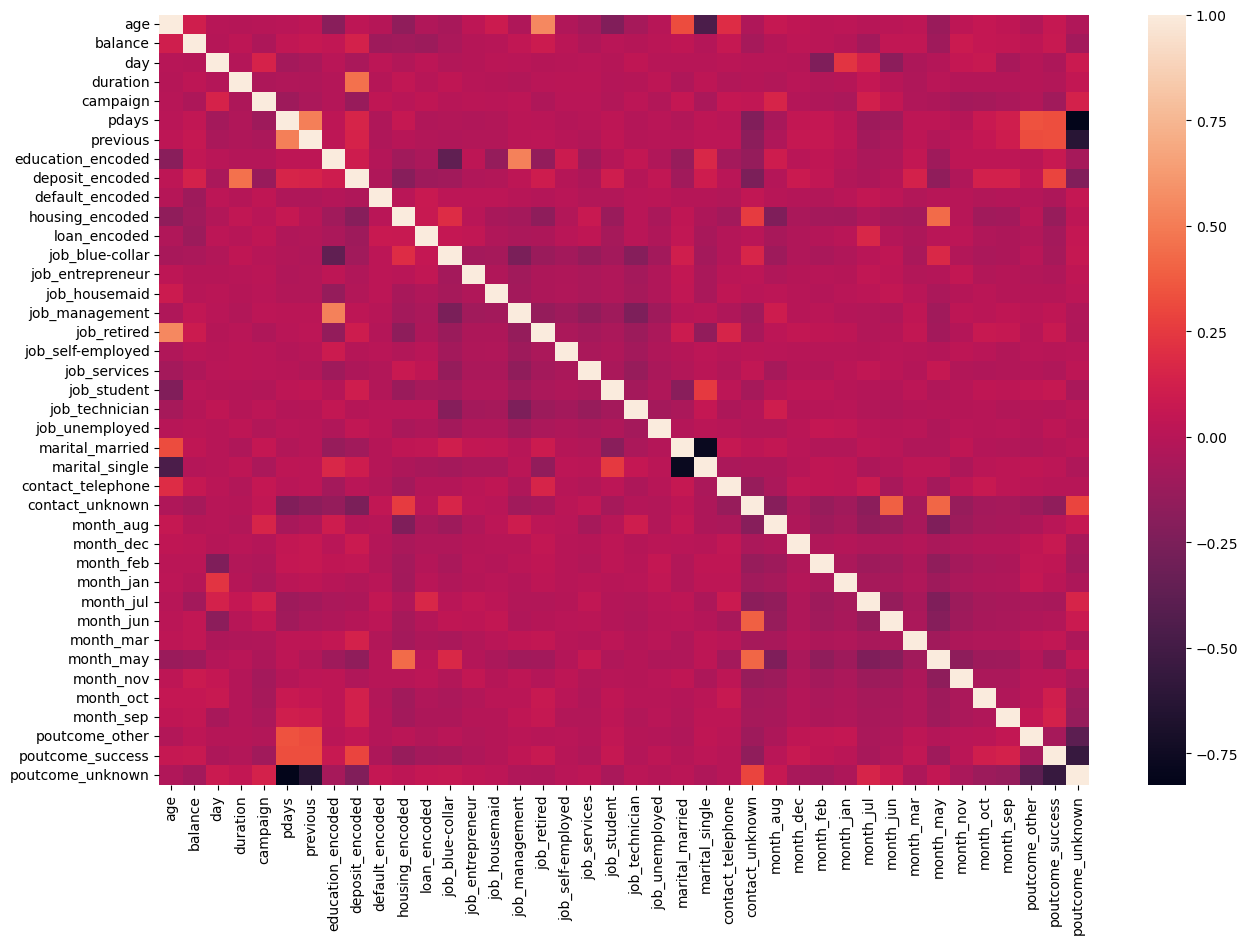

In [46]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(correlation_matrix)

### Задания 7 и 8

стратифицированное разбиение

рассчитайте необходимые показатели



In [50]:
X = filtered_df.drop(['deposit_encoded'], axis=1)
y = filtered_df['deposit_encoded']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [51]:
X_test.shape

(3335, 39)

In [52]:
y_test.mean().round(2)

0.46

### Задание 9

с помощью SelectKBest отберите 15 наиболее подходящих признаков


In [54]:
X = filtered_df.select_dtypes(include=['number']).drop(['deposit_encoded'], axis=1)

from sklearn.feature_selection import SelectKBest, f_classif

# Инициализация SelectKBest с использованием f_classif
selector = SelectKBest(score_func=f_classif, k=15)

# Применение SelectKBest к обучающим данным
X_new = selector.fit_transform(X, y)

# Получение индексов отобранных признаков
selected_feature_indices = selector.get_support(indices=True)

# Получение списка имен отобранных признаков
selected_feature_names = X.columns[selected_feature_indices]

# Вывод результата
print("Отобранные признаки:")
print(selected_feature_names)

Отобранные признаки:
Index(['balance', 'duration', 'campaign', 'pdays', 'previous',
       'housing_encoded', 'loan_encoded', 'job_student', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


### Задание 10

нормализуйте данные с помощью minmaxsxaler

In [55]:
from sklearn.preprocessing import MinMaxScaler

# нормализуйте данные с помощью minmaxsxaler
X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, random_state = 42, test_size = 0.33)

# Инициализация объекта MinMaxScaler
scaler = MinMaxScaler()

# Применение нормализации к X_train
X_train_scaled = scaler.fit_transform(X_train)

# Применение тех же параметров нормализации к X_test
X_test_scaled = scaler.transform(X_test)

# Вывод результата
print(X_test_scaled[:, 0].mean().round(2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

обучите логистическую регрессию и рассчитайте метрики качества


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Создадим модель логистической регрессии с параметром оптимизации 'sag' и random_state=42
model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Обучим модель на обучающем наборе данных
model.fit(X_train_scaled, y_train)

# Предскажем значения на тестовом наборе данных
y_pred = model.predict(X_test_scaled)

# Оценим точность модели
# accuracy = np.mean(y_pred == y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {round(accuracy,2)}")

Точность модели: 0.81


### Задания 2,3,4

обучите решающие деревья, настройте максимальную глубину

In [57]:
from sklearn.tree import DecisionTreeClassifier

# Создадим модель решающего дерева с заданными параметрами
tree_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучим модель решающего дерева на обучающем наборе данных
tree_model.fit(X_train_scaled, y_train)

# Предскажем значения на тестовом наборе данных
tree_y_pred_test = tree_model.predict(X_test_scaled)

# Оценим точность модели решающего дерева
tree_accuracy = accuracy_score(y_test, tree_y_pred_test)
print(f"Точность модели решающего дерева: {tree_accuracy}")

# Предскажем значения на обучающей выборке
tree_y_pred_train = tree_model.predict(X_train_scaled)

# Оценим точность модели решающего дерева на обучающей выборке
tree_accuracy_train = accuracy_score(y_train, tree_y_pred_train)
print(f"Точность модели решающего дерева на тренировочной выборке: {tree_accuracy_train}")

Точность модели решающего дерева: 0.7523238380809595
Точность модели решающего дерева на тренировочной выборке: 0.9997045790251108


### Задание 5

подберите оптимальные параметры с помощью gridsearch

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [3,5,7],
              'min_samples_split': [2, 5, 7, 10]}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1  # Set n_jobs to 1
)
grid_search.fit(X_train_scaled, y_train)

# Теперь можно использовать другие атрибуты или методы
print("accuracy на обучающем наборе: {:.2f}".format(grid_search.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

обучите на ваших данных случайный лес

In [59]:
from sklearn.ensemble import RandomForestClassifier

# Ваши параметры
n_estimators = 100
criterion = 'gini'
min_samples_leaf = 5
max_depth = 10
random_state = 42

# Создание модели случайного леса
random_forest = RandomForestClassifier(
    n_estimators=n_estimators,
    criterion=criterion,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=random_state
)

# Обучение модели на вашем наборе данных
# X_train и y_train - ваши обучающие данные и метки
random_forest.fit(X_train_scaled, y_train)

# Теперь ваш случайный лес обучен и готов к использованию

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [60]:
from sklearn.metrics import accuracy_score, recall_score

# Прогнозы на тестовых данных
y_pred = random_forest.predict(X_test_scaled)

# Оценка accuracy
accuracy = accuracy_score(y_test, y_pred)

# Оценка recall
recall = recall_score(y_test, y_pred)

# Вывод результатов
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.83
Recall: 0.84


### Задания 2 и 3

используйте для классификации градиентный бустинг и сравните качество со случайным лесом


In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

# Ваши параметры
learning_rate = 0.05
n_estimators = 300
min_samples_leaf = 5
max_depth = 5
random_state = 42

# Создание модели градиентного бустинга
gradient_boosting = GradientBoostingClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=random_state
)

# Обучение модели на обучающих данных
gradient_boosting.fit(X_train_scaled, y_train)

# Прогнозы на тестовых данных
y_pred_gb = gradient_boosting.predict(X_test_scaled)

# Оценка accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Оценка recall
recall_gb = recall_score(y_test, y_pred_gb)

# Вывод результатов
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print(f'Gradient Boosting Recall: {recall_gb:.2f}')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

# Ваши параметры
learning_rate = 0.05
n_estimators = 300
min_samples_leaf = 5
max_depth = 5
random_state = 42

# Создание модели градиентного бустинга
gradient_boosting = GradientBoostingClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=random_state
)

# Обучение модели на обучающих данных
gradient_boosting.fit(X_train_scaled, y_train)

# Прогнозы на тестовых данных
y_pred_gb = gradient_boosting.predict(X_test_scaled)

# Оценка accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Оценка recall
recall_gb = recall_score(y_test, y_pred_gb)

# Вывод результатов
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print(f'Gradient Boosting Recall: {recall_gb:.2f}')

Gradient Boosting Accuracy: 0.83
Gradient Boosting Recall: 0.83
Gradient Boosting Accuracy: 0.83
Gradient Boosting Recall: 0.83


### Задание 4

объедините уже известные вам алгоритмы с помощью стекинга

In [62]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга


In [63]:
from sklearn.metrics import precision_score

# Получение предсказаний на тестовой выборке
y_pred = stack.predict(X_test_scaled)

# Вычисление метрики precision
precision = precision_score(y_test, y_pred)

# Вывод результата с округлением до двух знаков после точки-разделителя
print(f'Precision: {precision:.2f}')

Precision: 0.81


### Задание 5

оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга


Feature importance:
duration: 0.5700316725063395
poutcome_success: 0.1262254446917176
contact_unknown: 0.07833718294567539
housing_encoded: 0.05700276461028553
pdays: 0.03812627202776855
month_mar: 0.03124395067954335
balance: 0.022597953837513604
month_oct: 0.01862221768511235
month_sep: 0.015289707003271463
loan_encoded: 0.011322535364640604
campaign: 0.009165812682098597
month_may: 0.006264216493828561
poutcome_unknown: 0.006210953545380679
job_student: 0.00572093525949891
previous: 0.0038383806673254316


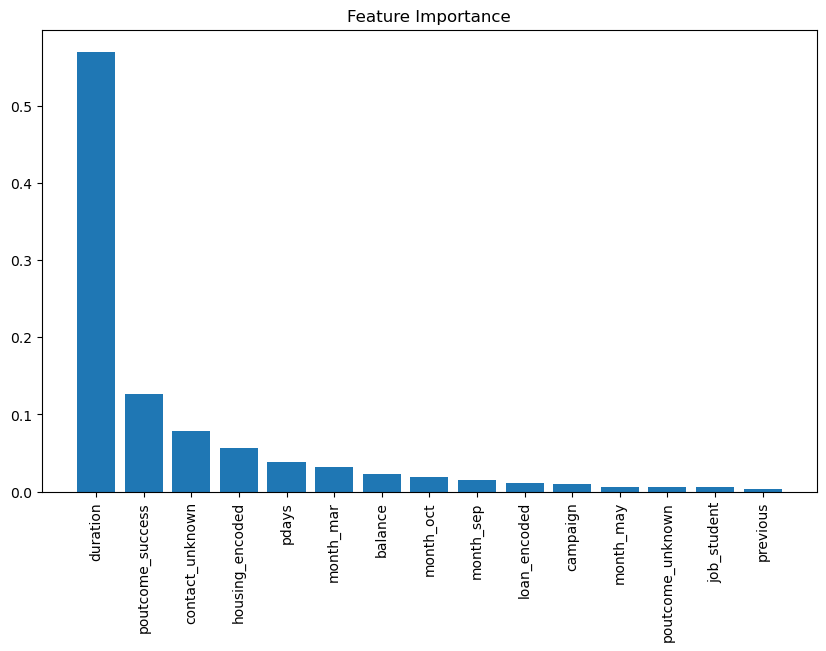

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt

# Создание и обучение модели
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)

# Получение важности признаков
importance = gb.feature_importances_

# Сортировка признаков по их важности
indices = np.argsort(importance)[::-1]

# Вывод важности признаков
print("Feature importance:")
for f in range(X_train_scaled.shape[1]):
    print(f"{selected_feature_names[indices[f]]}: {importance[indices[f]]}")

# Визуализация важности признаков (опционально)
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_scaled.shape[1]), importance[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)
plt.title("Feature Importance")
plt.show()

### Задания 6,7,8

реализуйте оптимизацию гиперпараметров с помощью Optuna


In [65]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score

In [66]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-05-16 16:18:55,686] A new study created in memory with name: RandomForestClassifier
[I 2024-05-16 16:18:56,032] Trial 0 finished with value: 0.8199306212551246 and parameters: {'n_estimators': 126, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8199306212551246.
[I 2024-05-16 16:18:56,331] Trial 1 finished with value: 0.8185840707964601 and parameters: {'n_estimators': 113, 'max_depth': 22, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8199306212551246.
[I 2024-05-16 16:18:56,886] Trial 2 finished with value: 0.8149319835495097 and parameters: {'n_estimators': 164, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8199306212551246.
[I 2024-05-16 16:18:57,236] Trial 3 finished with value: 0.8230088495575221 and parameters: {'n_estimators': 117, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8230088495575221.
[I 2024-05-16 16:18:57,712] Trial 4 finished with value: 0.8199936728883265 and parameters: {'n_

CPU times: user 8.32 s, sys: 84 ms, total: 8.4 s
Wall time: 8.16 s


In [67]:
# выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на тестовом наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 118, 'max_depth': 13, 'min_samples_leaf': 2}
f1_score на тестовом наборе: 0.83


In [68]:
def optuna_rf_accuracy_score(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.accuracy_score(y_test, model.predict(X_test_scaled))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf_accuracy_score, n_trials=20)

[I 2024-05-16 16:19:03,861] A new study created in memory with name: RandomForestClassifier
[I 2024-05-16 16:19:04,346] Trial 0 finished with value: 0.8341829085457272 and parameters: {'n_estimators': 166, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8341829085457272.
[I 2024-05-16 16:19:04,740] Trial 1 finished with value: 0.8266866566716642 and parameters: {'n_estimators': 121, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8341829085457272.
[I 2024-05-16 16:19:05,125] Trial 2 finished with value: 0.8257871064467767 and parameters: {'n_estimators': 144, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8341829085457272.
[I 2024-05-16 16:19:05,608] Trial 3 finished with value: 0.8278860569715143 and parameters: {'n_estimators': 175, 'max_depth': 23, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8341829085457272.
[I 2024-05-16 16:19:06,145] Trial 4 finished with value: 0.8350824587706147 and parameters: {'n

In [69]:
# выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("accuracy на тестовом наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2}
accuracy на тестовом наборе: 0.84


#### Общий вывод

Проведена предобработка признаков: пропущенные значения заменены простыми способами (медиана, мода), а выбросы баланса удалены методом Тьюкки.

Проведен разведывательный анализ данных с целью выявления влияния признаков на целевой признак.

Выполнено кодирование признаков и масштабирование значений.

Проведена оценка влияния признаков на целевой признак с помощью корреляции Кендалла (из-за отсутствия монотонной связи и ненормального распределения признаков). Отобраны наиболее значимых признаков для построения моделей. 

Построены простые базовые модели: логистическая регрессия и решающее дерево.

Созданы ансамблевые модели: случайный лес, градиентный бустинг на решающих деревьях, стекинг из деревьев, регрессии и бустинга.

Проведены примеры подбора гиперпараметров. 

На каждом этапе моделирования оценивались метрики качества классификации. Ансамблевые модели показали лучшие результаты. Существенной разницы между ансамблевыми моделями на данном датасете не выявлено. 